<a href="https://colab.research.google.com/github/who-knows-its-nebulose/Chair_Style_classifier/blob/main/classification_chair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
ls "/content/drive/My Drive/Colab Notebooks"

 chairs/
 chairs_test/
 checkpoints/
 classification_chair.ipynb
 classification_efficientNET.ipynb
 Classificaton_finetune.ipynb
'Copy of classification_chair.ipynb'
'Copy of Roboflow-EfficientNet-Classification.ipynb'
 Untitled0.ipynb
 Untitled1.ipynb


In [11]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

img_height = 224
img_width = 224
batch_size = 16

In [12]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/chairs/',
    labels = 'inferred',
    label_mode = "categorical",
    class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.2,
    subset = "training",
)

ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/chairs/',
    labels = 'inferred',
    label_mode = "categorical",
    class_names= ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.2,
    subset = "validation",
)


  

Found 1705 files belonging to 5 classes.
Using 1364 files for training.
Found 1705 files belonging to 5 classes.
Using 341 files for validation.


In [13]:
class_names = ds_train.class_names
print(class_names)

['Farmhouse', 'Industrial', 'Midcentury', 'Tropical', 'Victorian']


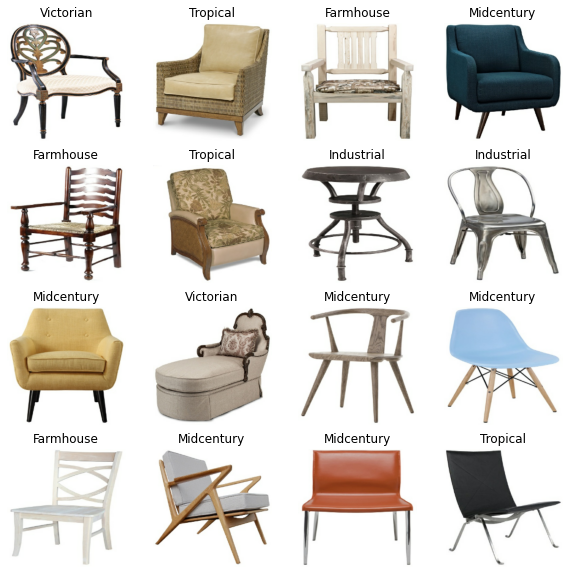

In [14]:
#look at the dataset

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
    int_labels = np.argmax(labels, axis=-1)
    plt.title(class_names[int_labels[i]])
    plt.axis("off")

Augment and rescale

In [15]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
IMG_SIZE = 224

# resize_and_rescale = tf.keras.Sequential([
#   layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
#   layers.experimental.preprocessing.Rescaling(1./255)
# ])

img_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
  ]
)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

#set buffer_size to AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# ds_train = prepare(ds_train, shuffle=True, augment=True)
# ds_valid = prepare(ds_valid)

base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, 
                                                           img_width,
                                                              3),
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = img_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )

model.summary()


9412608/9406464 [==============================] - 0s 0us/step
(16, 7, 7, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      

In [16]:
# for image, label in ds_train.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         #aug_img = img_augmentation(image)
#         aug_image = img_augmentation(tf.expand_dims(image[0], axis=0))
#         plt.imshow(aug_image[0]/255)
# #        plt.title(int(labels[i]))
# #       plt.title("{}".format(format_label(label)))
#         plt.axis("off")

PREFETCH

In [17]:
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE) 
ds_valid = ds_valid.prefetch(buffer_size=AUTOTUNE)

len(model.trainable_variables)



2

In [18]:
initial_epochs = 40

history = model.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_valid)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



Epoch 1/40
86/86 [==============================] - 666s 8s/step - loss: 1.7979 - accuracy: 0.2544 - val_loss: 1.6173 - val_accuracy: 0.2815
Epoch 2/40
86/86 [==============================] - 5s 56ms/step - loss: 1.4963 - accuracy: 0.3776 - val_loss: 1.4339 - val_accuracy: 0.3695
Epoch 3/40
86/86 [==============================] - 5s 55ms/step - loss: 1.3277 - accuracy: 0.4472 - val_loss: 1.3129 - val_accuracy: 0.4633
Epoch 4/40
86/86 [==============================] - 5s 57ms/step - loss: 1.2019 - accuracy: 0.5359 - val_loss: 1.2237 - val_accuracy: 0.5308
Epoch 5/40
86/86 [==============================] - 5s 56ms/step - loss: 1.1216 - accuracy: 0.5579 - val_loss: 1.1384 - val_accuracy: 0.5982
Epoch 6/40
86/86 [==============================] - 5s 57ms/step - loss: 1.0315 - accuracy: 0.5975 - val_loss: 1.0817 - val_accuracy: 0.6393
Epoch 7/40
86/86 [==============================] - 5s 56ms/step - loss: 0.9639 - accuracy: 0.6386 - val_loss: 1.0350 - val_accuracy: 0.6686
Epoch 8/40
86

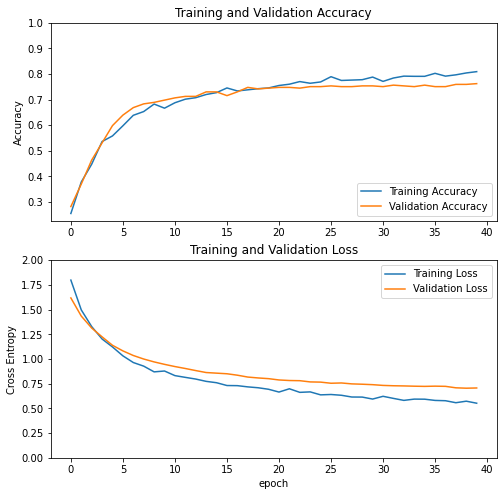

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fine tune to see if it can improve

In [23]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

base_learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
model.summary()

len(model.trainable_variables)

Number of layers in the base model:  155
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Drop

58

In [24]:
fine_tune_epochs =15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_valid)

Epoch 40/55
86/86 [==============================] - 6s 68ms/step - loss: 0.5029 - accuracy: 0.8255 - val_loss: 0.6647 - val_accuracy: 0.7918
Epoch 41/55
86/86 [==============================] - 5s 62ms/step - loss: 0.4889 - accuracy: 0.8343 - val_loss: 0.6179 - val_accuracy: 0.7977
Epoch 42/55
86/86 [==============================] - 5s 61ms/step - loss: 0.4566 - accuracy: 0.8372 - val_loss: 0.5894 - val_accuracy: 0.8094
Epoch 43/55
86/86 [==============================] - 5s 61ms/step - loss: 0.4082 - accuracy: 0.8453 - val_loss: 0.6033 - val_accuracy: 0.8065
Epoch 44/55
86/86 [==============================] - 5s 61ms/step - loss: 0.3868 - accuracy: 0.8702 - val_loss: 0.5956 - val_accuracy: 0.8065
Epoch 45/55
86/86 [==============================] - 5s 62ms/step - loss: 0.3686 - accuracy: 0.8754 - val_loss: 0.5669 - val_accuracy: 0.8299
Epoch 46/55
86/86 [==============================] - 5s 61ms/step - loss: 0.3518 - accuracy: 0.8783 - val_loss: 0.6203 - val_accuracy: 0.7947
Epoch 

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



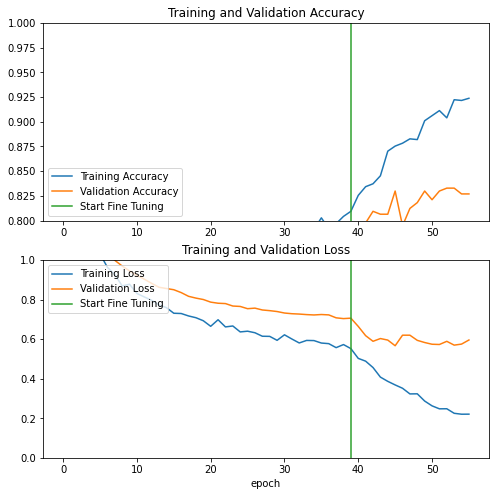

In [27]:


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:



# N_CLASSES = 5

# #kernel_initializer = tf.keras.initializers.glorot_uniform(seed=1337)
# trained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
#                       include_top=False,
#                       weights='imagenet',
#                       alpha=0.5,
#                       input_shape=[224, 224, 3],
#                       pooling='max')
# output = tf.keras.layers.Dense(N_CLASSES, activation='softmax', kernel_initializer=kernel_initializer)(trained_model.output)
# model = tf.keras.Model(inputs=trained_model.input, outputs=output)

# # Callback to save weights, based on val_acc
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#   './checkpoints/{epoch:02d}_{val_acc:.4f}.h5',
#   save_weights_only=False,
#   verbose=1,
#   monitor='val_acc',
#   save_best_only=True,
#   mode='max'
# )


In [ ]:
# print(len(ds_train))

In [ ]:
# # Callbackto plot data on TensorBoard
# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#   log_dir='./logs/furniture_classifier',
#   histogram_freq=0,
#   batch_size=BATCH_SIZE
# )

# # Callback to reduce learning rate after plateaus
# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#   monitor='val_acc',
#   factor=0.5,
#   patience=4,
#   min_lr=1e-6
# )

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#   monitor='val_acc',
#   patience=20,
#   mode='max',
# )

# TRAIN_DATASET_SIZE = len(train_batches)
# VAL_DATASET_SIZE   = len(val_batches)

# # Weighted losses for class equilibrium
# unique, counts = np.unique(ds_train.classes, return_counts=True)
# class_weigths = dict(zip(unique, np.true_divide(counts.sum(), N_CLASSES*counts)))


# if Path('./checkpoints/').exists():
#   epoch_number_array = []
#   val_accuracy_array = []
#   file_name_array = []
#   for file in os.listdir('./checkpoints/'):
#     epoch, val_acc = re.search(r'(\d\d)_(\d\.\d{4})\.h5', file).group(1,2)
#     epoch_number_array.append(int(epoch))
#     val_accuracy_array.append(float(val_acc))
#     file_name_array.append(file)

#   if len(val_accuracy_array) == 0:
#     INITIAL_EPOCH = 0
#   else:
#     highest_acc = val_accuracy_array.index(max(val_accuracy_array))
#     INITIAL_EPOCH = epoch_number_array[highest_acc]
#     model_checkpoint_callback.best = val_accuracy_array[highest_acc]
#     model.load_weights('./checkpoints/'+file_name_array[highest_acc])
# else:
#   os.makedirs('./checkpoints/')
# #   INITIAL_EPOCH = 0
 
# TOTAL_EPOCHS = 10


# Prepare model to run

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
# model.compile(optimizer = tf.keras.optimizers.Adam(),
#               loss = 'categorical_crossentropy',
#               metrics = ['accuracy']
#               )



# model.fit(
#      ds_train, epochs=TOTAL_EPOCHS, callbacks=callbacks, validation_data=ds_valid,
#  )
# Starts training the model
# model.fit_generator(train_batches,
#                     epochs=TOTAL_EPOCHS,
#                     verbose=1,
#                     steps_per_epoch=TRAIN_DATASET_SIZE,
#                     validation_data=val_batches,
#                     validation_steps=VAL_DATASET_SIZE,
#                     #initial_epoch=INITIAL_EPOCH,
#                     #class_weight=class_weigths,
#                     use_multiprocessing=True,
#                     workers=4,
#                     callbacks=[model_checkpoint_callback, tensorboard_callback, reduce_lr_callback, early_stopping_callback]
#                     )

Prev attempts


In [ ]:

# # example of tending the vgg16 model
# from keras.applications.vgg16 import VGG16
# from keras.models import Model
# from keras.layers import Dense
# from keras.layers import Flatten
# # load model without classifier layers
# model = VGG16(include_top=False, input_shape=(224, 224, 3))
# for layer in model.layers:
# 	layer.trainable = False

# # add new classifier layers
# flat1 = Flatten()(model.layers[-1].output)
# class1 = Dense(1024, activation='relu')(flat1)
# output = Dense(5, activation='softmax')(class1)
# # define new model
# model = Model(inputs=model.inputs, outputs=output)
# # summarize
# model.summary()

In [ ]:
# #Adam optimizer

# epochs = 50
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss= tf.keras.losses.CategoricalCrossentropy(),
#     #loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )
# model.fit(
#     ds_train, epochs=epochs, callbacks=callbacks, validation_data=ds_valid,
# )

#1 Try VGG16

In [ ]:

# model = Sequential()
# model.add(Flatten(input_shape=train_features.shape[1:]))
# model.add(Dense(4096, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(8, activation='softmax'))


# # In[33]:


# model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])


# # In[34]:

# callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
# # autosave best Model
# best_model_file = "./batch_normalized_weights.h5"
# best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)


# # In[ ]:

# history = model.fit(train_features, onehot_train, batch_size=10, nb_epoch=10,
#               validation_data=(valid_features,onehot_valid),shuffle=True,callbacks = [callbacks,best_model])


# # In[ ]:

# # summarize history for accuracy
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
# plt.title('model accuracy'); plt.ylabel('accuracy');
# plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# # summarize history for loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
# plt.title('model loss'); plt.ylabel('loss');
# plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
# plt.show()

EXAMPLE FROM KERAS GUIDE ON XCEPTION

In [ ]:
# image_size = (img_height, img_width)

# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     # Image augmentation block
#     x = img_augmentation(inputs)
#     #x = inputs

#     # Entry block
#     x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
#     x = layers.Conv2D(32, 1, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.Conv2D(64, 1, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [128, 256, 512, 728]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         activation = "sigmoid"
#         units = 1
#     else:
#         activation = "softmax"
#         units = num_classes

#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(units, activation=activation)(x)
#     return keras.Model(inputs, outputs)


# model = make_model(input_shape=image_size + (3,), num_classes=5)
# #keras.utils.plot_model(model, show_shapes=True)


In [ ]:
# #Adam optimizer

# epochs = 50
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss= tf.keras.losses.SparseCategoricalCrossentropy(),
#     #loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )
# model.fit(
#     ds_train, epochs=epochs, callbacks=callbacks, validation_data=ds_valid,
# )